In [1]:
%config Completer.use_jedi = False
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pprint
import healpy as hp
import reproject as rpj
from astropy.io import fits
from astropy.wcs import WCS
from tqdm import tnrange, tqdm_notebook
import pandas as pd

In [2]:
import pymongo
client = pymongo.MongoClient()  # default connection (ie, local)
mydb = client['racs']  # Create/open database
mycol = mydb['spice']  # Create/open collection



In [10]:
# Quick check to confirm load
x = mycol.find_one()

x['q_file']

'J215407-515017.cutout.q.fits'

In [11]:
def cone_search(ra, dec, radius, collection=mycol, field='coords.loc'):
    
    scaling = wgs_scale(dec)
    meter_radius = radius * scaling
    lon, lat = ra-180., dec
    
    cursor = collection.find({'coords.loc': {
    '$nearSphere': { 
        '$geometry': { 'type': 'Point', 
                      'coordinates': [lon, lat]}, 
        '$maxDistance': meter_radius
    } } })
    
    return cursor

In [14]:
def wgs_scale(lat):
    # Get scaling to convert degrees to meters at a given geodetic latitude (declination)
    
    # Values from WGS 84
    a = 6378137.000000000000 # Semi-major axis of Earth
    b = 6356752.314140000000 # Semi-minor axis of Earth
    e = 0.081819190842600 # eccentricity
    angle = np.radians(1.0)
    
    # Compute radius of curvature along meridian (see https://en.wikipedia.org/wiki/Meridian_arc)
    rm = a * (1 - np.power(e, 2)) / np.power( ( (1 - np.power(e, 2) * np.power( np.sin(np.radians(lat)), 2) ) ), 1.5)
    
    # Compute length of arc at this latitude (meters/degree)
    arc = rm * angle
    return arc

In [16]:
ra = 325
dec = -50
rad = 2

#cursor = cone_search(ra, dec, rad)
#df = pd.DataFrame(cursor)
#print(df)
#for doc in cursor:
#    pprint.pprint(doc,indent=1)

In [342]:
def printTable(myDict, colList=None):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
    If column names (colList) aren't specified, they will show in random order.
    Author: Thierry Husson - Use it as you want but don't blame me.
    """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] if item[col] is not None else '') for col in colList])
    colSize = [max(map(len,col)) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    myList.insert(1, ['-' * i for i in colSize]) # Seperating line
    for item in myList: print(formatStr.format(*item))

In [421]:
cursor.count()

/home/athomson/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  """Entry point for launching an IPython kernel.


71

In [422]:
#hdu = fits.open(cursor[0]['i_file'], mode='denywrite')[0]
#wcs = WCS(hdu)

In [4]:
cursor = mycol.find({})

In [17]:
head = cursor[0]['header']
wcs_head = WCS(head).dropaxis(2)
new_head = wcs_head.to_header()
new_head['CRVAL1'] = ra
new_head['CRVAL2'] = dec
new_head['CDELT1'] *= 1
new_head['CDELT2'] *= 1
new_head['NAXIS'] = new_head['WCSAXES']
new_head['NAXIS1'] = int(abs(rad/new_head['CDELT1']))
new_head['NAXIS2'] = int(abs(rad/new_head['CDELT2']))
#new_head['NAXIS3'] = head['NAXIS3']

new_head['CRPIX1'] = new_head['NAXIS1']//2
new_head['CRPIX2'] = new_head['NAXIS2']//2

In [289]:
#i_array, footprint = rpj.reproject_interp(hdu, new_head)

In [23]:
new_head

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                 1799 / Pixel coordinate of reference point            
CRPIX2  =                 1799 / Pixel coordinate of reference point            
CDELT1  =  -0.0005555555555556 / [deg] Coordinate increment at reference point  
CDELT2  =   0.0005555555555556 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---SIN'           / Right ascension, orthographic/synthesis project
CTYPE2  = 'DEC--SIN'           / Declination, orthographic/synthesis projection 
CRVAL1  =                  325 / [deg] Coordinate value at reference point      
CRVAL2  =                  -50 / [deg] Coordinate value at reference point      
LONPOLE =                180.0 / [deg] Native longitude of celestial pole       
LATPOLE =      -52.349738888

In [28]:
def makelarge(args):
    new_head, outdir, cursor = args
    hdu = fits.open(f"{outdir}/{cursor['i_mu_file']}", mode='denywrite')[0]
    temp_arr, footprint = rpj.reproject_interp((hdu.data,WCS(hdu)), new_head)
    return temp_arr

In [7]:
import schwimmbad
from multiprocessing import cpu_count

In [8]:
n_cores = cpu_count()
use_mpi = False

In [9]:
n_cores

16

In [20]:
from tqdm.notebook import tqdm

In [31]:
arr.shape

(3599, 3599)

In [29]:
arr = makelarge([new_head, '/Volumes/DATA/possumpilot/cutouts',cursor[0]])

In [33]:
with schwimmbad.choose_pool(mpi=use_mpi, processes=n_cores) as pool:
    if use_mpi:
        output=list(pool.map(makelarge, [[new_head, '/Volumes/DATA/possumpilot/cutouts', cursor[i], i] for i in range(cursor.count())]))
    else:
        output=list(tqdm(pool.imap(makelarge, 
                                          [[new_head, '/Volumes/DATA/possumpilot/cutouts',cursor[i]] for i in range(cursor.count())]),
                     total = cursor.count()
                     ))
i_array = np.nanmean(np.array(output), axis=0)

/Users/tho822/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  
/Users/tho822/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  import sys


KeyboardInterrupt: 

In [384]:
#for i in tnrange(cursor.count()):
#    if i==0:
#        continue
#    else:
#        hdu = fits.open(cursor[i]['i_file'], mode='denywrite')[0]
#        temp_arr, footprint = rpj.reproject_interp(hdu, new_head)
#        i_array = np.nanmean(np.array([i_array,temp_arr]), axis=0)
#        #ind1 = np.where(np.isfinite(i_array))
#        #ind2 = np.where(np.isfinite(temp_arr))
#        #nan_count = npnp.isnan(i_array)
#        #nan

In [36]:
i_arra

(899,)

In [13]:
from matplotlib.colors import LogNorm

<IPython.core.display.Javascript object>


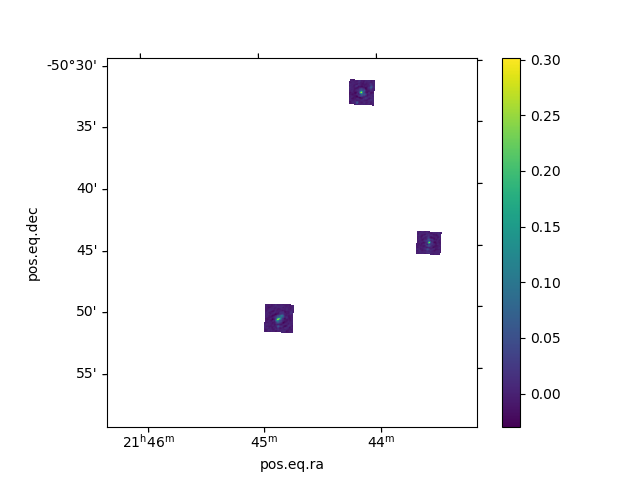

In [37]:
plt.figure()
ax = plt.subplot(projection=WCS(new_head))
im = ax.imshow(i_array)
plt.colorbar(im)
plt.show()

In [167]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [196]:
junk = SkyCoord(ra='11h00m26s', dec='-29d57m')
junk.ra.deg
junk.dec.deg

-29.95

In [53]:
NSIDE = 2048
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 2048 is 0.029 deg


In [54]:
hpx_arr = np.ones_like(hp.nside2npix)*np.nan

In [55]:
array, foot = rpj.reproject_to_healpix(
                                        (hdu.data[0],wcs.dropaxis(2)),
                                        'g',
                                        nside=NSIDE)

In [56]:
all(np.isnan(array))

False

In [15]:
mydoc = mycol.find({}).sort("flux_peak", -1)

In [23]:
print(mydoc[0]['ra_deg_cont'])
print(mydoc[0]['component_1']['ra_deg_cont'])
print(mydoc[0]['component_2']['ra_deg_cont'])
print(mydoc[0]['component_3']['ra_deg_cont'])

328.530803
323.229717
323.229717
323.229717


In [25]:
from spiceracs.utils import getdata

In [26]:
datadict = getdata('/Volumes/DATA/possumpilot/mosaics/', '/Volumes/DATA/possumpilot/selavy/',\
        '/Volumes/DATA/possumpilot/selavy/image.i.SB10168.cont.taylor.0.restored.fits')

Getting table data from /Volumes/DATA/possumpilot/selavy/selavy-image.i.SB10168.cont.taylor.0.restored.islands.xml...
Getting table data from /Volumes/DATA/possumpilot/selavy/selavy-image.i.SB10168.cont.taylor.0.restored.components.xml...
Getting spectral data from: [['/Volumes/DATA/possumpilot/mosaics/image.restored.i.SB10168.contcube.linmos.fits'], ['/Volumes/DATA/possumpilot/mosaics/image.restored.q.SB10168.contcube.linmos.fits'], ['/Volumes/DATA/possumpilot/mosaics/image.restored.u.SB10168.contcube.linmos.fits'], ['/Volumes/DATA/possumpilot/mosaics/image.restored.v.SB10168.contcube.linmos.fits']] 

Getting source location data from: /Volumes/DATA/possumpilot/selavy/image.i.SB10168.cont.taylor.0.restored.fits 



In [115]:

source_dict = {}
datadict['i_tab_comp'].add_index('col_island_id')
for i in range(2):
    for name in datadict['i_tab'].colnames:
        source_dict[name.replace('col_', '')
                    ] = datadict['i_tab'][name][i]

    components = Table(datadict['i_tab_comp'].loc[datadict['i_tab']['col_island_id'][i]])
    for comp, row in enumerate(components):
        source_dict[f'component_{comp+1}'] = {}
        print(type(row))
        for name in components.colnames:
            source_dict[f'component_{comp+1}'][name.replace('col_', '')
                        ] = row[name]

<class 'astropy.table.row.Row'>
<class 'astropy.table.row.Row'>
<class 'astropy.table.row.Row'>
<class 'astropy.table.row.Row'>


In [113]:
from astropy.table import Table

In [114]:
Table(components)

col_island_id,col_component_id,col_component_name,col_ra_hms_cont,col_dec_dms_cont,col_ra_deg_cont,col_dec_deg_cont,col_ra_err,col_dec_err,col_freq,col_flux_peak,col_flux_peak_err,col_flux_int,col_flux_int_err,col_maj_axis,col_min_axis,col_pos_ang,col_maj_axis_err,col_min_axis_err,col_pos_ang_err,col_maj_axis_deconv,col_min_axis_deconv,col_pos_ang_deconv,col_maj_axis_deconv_err,col_min_axis_deconv_err,col_pos_ang_deconv_err,col_chi_squared_fit,col_rms_fit_gauss,col_spectral_index,col_spectral_curvature,col_spectral_index_err,col_spectral_curvature_err,col_rms_image,col_has_siblings,col_fit_is_estimate,col_spectral_index_from_TT,col_flag_c4,col_comment
--,--,,,,deg,deg,arcsec,arcsec,MHz,mJy/beam,mJy/beam,mJy,mJy,arcsec,arcsec,deg,arcsec,arcsec,deg,arcsec,arcsec,deg,arcsec,arcsec,deg,--,mJy/beam,--,--,--,--,mJy/beam,,,,,
bytes20,bytes24,bytes26,bytes12,bytes13,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,bytes100
SB10168_island_10,SB10168_component_10a,J214458-515010,21:44:58.2,-51:50:10,326.242658,-51.836381,0.15,0.20,1295.5,146.551,3.777,344.066,10.633,20.83,8.88,146.20,0.54,0.03,1.09,18.37,3.42,-31.07,0.02,0.63,6.11,6946759.500,151415.312,-0.74,-99.00,0.00,0.00,0.089,0,0,1,1,


In [95]:
components = datadict['i_tab_comp'].loc[datadict['i_tab']['col_island_id'][1]]
components.colnames

['col_island_id',
 'col_component_id',
 'col_component_name',
 'col_ra_hms_cont',
 'col_dec_dms_cont',
 'col_ra_deg_cont',
 'col_dec_deg_cont',
 'col_ra_err',
 'col_dec_err',
 'col_freq',
 'col_flux_peak',
 'col_flux_peak_err',
 'col_flux_int',
 'col_flux_int_err',
 'col_maj_axis',
 'col_min_axis',
 'col_pos_ang',
 'col_maj_axis_err',
 'col_min_axis_err',
 'col_pos_ang_err',
 'col_maj_axis_deconv',
 'col_min_axis_deconv',
 'col_pos_ang_deconv',
 'col_maj_axis_deconv_err',
 'col_min_axis_deconv_err',
 'col_pos_ang_deconv_err',
 'col_chi_squared_fit',
 'col_rms_fit_gauss',
 'col_spectral_index',
 'col_spectral_curvature',
 'col_spectral_index_err',
 'col_spectral_curvature_err',
 'col_rms_image',
 'col_has_siblings',
 'col_fit_is_estimate',
 'col_spectral_index_from_TT',
 'col_flag_c4',
 'col_comment']

In [82]:
type(datadict['i_tab_comp'].loc[datadict['i_tab']['col_island_id'][0]])

astropy.table.table.Table

In [76]:
row

col_island_id,col_component_id,col_component_name,col_ra_hms_cont,col_dec_dms_cont,col_ra_deg_cont,col_dec_deg_cont,col_ra_err,col_dec_err,col_freq,col_flux_peak,col_flux_peak_err,col_flux_int,col_flux_int_err,col_maj_axis,col_min_axis,col_pos_ang,col_maj_axis_err,col_min_axis_err,col_pos_ang_err,col_maj_axis_deconv,col_min_axis_deconv,col_pos_ang_deconv,col_maj_axis_deconv_err,col_min_axis_deconv_err,col_pos_ang_deconv_err,col_chi_squared_fit,col_rms_fit_gauss,col_spectral_index,col_spectral_curvature,col_spectral_index_err,col_spectral_curvature_err,col_rms_image,col_has_siblings,col_fit_is_estimate,col_spectral_index_from_TT,col_flag_c4,col_comment
--,--,,,,deg,deg,arcsec,arcsec,MHz,mJy/beam,mJy/beam,mJy,mJy,arcsec,arcsec,deg,arcsec,arcsec,deg,arcsec,arcsec,deg,arcsec,arcsec,deg,--,mJy/beam,--,--,--,--,mJy/beam,,,,,
bytes20,bytes24,bytes26,bytes12,bytes13,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,bytes100
SB10168_island_1,SB10168_component_1c,J215405-515022,21:54:05.7,-51:50:22,328.523745,-51.839662,1.37,1.57,1295.5,13.690,6.984,7.701,7.825,7.33,6.05,146.82,4.56,1.31,116.76,0.00,0.00,22.68,0.00,0.00,15.37,41220.117,10374.214,-0.17,-99.00,0.06,0.00,1.088,1,0,1,1,


In [48]:
source_dict

{'island_id': 'SB10168_island_1',
 'island_name': 'J215407-515017',
 'n_components': 3,
 'ra_hms_cont': '21:54:07.4',
 'dec_dms_cont': '-51:50:17',
 'ra_deg_cont': 328.530803,
 'dec_deg_cont': -51.838119,
 'freq': 1295.5,
 'maj_axis': 28.28,
 'min_axis': 8.51,
 'pos_ang': 149.47,
 'flux_int': 3662.431,
 'flux_int_err': 0.0,
 'flux_peak': 2013.824,
 'mean_background': 0.062,
 'background_noise': 1.09,
 'max_residual': 30.925,
 'min_residual': -35.059,
 'mean_residual': 1.732,
 'rms_residual': 11.29,
 'stdev_residual': 11.157,
 'x_min': 3413,
 'x_max': 3442,
 'y_min': 4190,
 'y_max': 4216,
 'n_pix': 383,
 'solid_angle': 0.43,
 'beam_area': 0.02,
 'x_ave': 3429.14,
 'y_ave': 4202.14,
 'x_cen': 3428.86,
 'y_cen': 4199.67,
 'x_peak': 3427,
 'y_peak': 4197,
 'flag_i1': 0,
 'flag_i2': 0,
 'flag_i3': 0,
 'flag_i4': 0,
 'comment': '',
 'component_1': {'island_id': 'SB10168_island_1',
  'component_id': 'SB10168_component_1b',
  'component_name': 'J215406-515007',
  'ra_hms_cont': '21:54:06.6',
 

In [12]:
snrs = []
for doc in mydoc:
    snrs.append(doc['rm_summary']['snrPIchan'])
snrs = np.array(snrs)

KeyError: 'rm_summary'

<IPython.core.display.Javascript object>


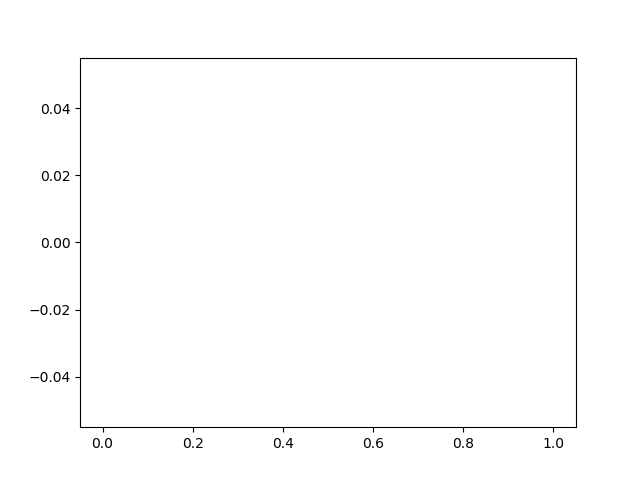

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

In [13]:
plt.figure()
plt.hist(snrs)